# Large Scale ESG Report Analysis

**By Tobias Schimanski and based on my paper: "Bridiging the Gap in ESG Measurement: Using NLP to Quantify Environmental, Social, and Governance Communication"**

This notebook serves as a basis for applying AI Natural Language Processing tools to corporate sustainability reports. It is particularily tailored for newcomers to the field with limited or no prior experience. In this tutorial, you can only press play and will be fine.

If you are already advanced, you might just [want to read the paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4622514) and or go directly to the [models on HuggingFace](https://huggingface.co/ESGBERT).

**In this tutorial, we learn how to use GPUs to facilitate large-scale analyses of multiple annual reports.**

This tutorial is the second of a series of tutorials. The first toutial [is here](https://medium.com/@schimanski.tobi/analyzing-esg-with-ai-and-nlp-tutorial-1-report-analysis-towards-esg-risks-and-opportunities-8daa2695f6c5).

## SET RUNTIME TO GPU

In order to use the models on large-scale, we want to use GPUs (processing units that are super fast). For this, we gut on "Runtime" underneath the tutorial name, choose "Change runtime type" and then select any "GPU", probably "T4 GPU" if you are not a premium user like me (no flex).

## Import libraries

We start by importing some standard libraries as well as the "transformers" one. This will help us to use the tools.

In [ ]:
%pip install transformers
%pip install tika

In [1]:
# standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline # for using the models

import spacy # for sentence extraction
from tika import parser # for the report extraction

/Users/andrew.mueller/y/envs/mypy311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/andrew.mueller/y/envs/mypy311/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/andrew.mueller/y/envs/mypy311/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0D991121-1B29-38E8-B953-7A27DA9FCC9B> /Users/andrew.mueller/y/envs/mypy311/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/Users/andrew.mueller/y/envs/mypy311/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/andrew.mueller/y/envs/mypy311/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/andrew.mueller/y/envs/m

In [43]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

tensor([1.], device='mps:0')
Using device: mps


## Step 1: Load models

We are going to use models of the [ESG BERT project](https://huggingface.co/ESGBERT). In this tutorial, we use GPUs to speed up the process enourmously in comparison to Tutorial 1. For this tutroial, we want to detect environmental actions made by companies.

In [44]:
### Load the models (takes ca. 1 min)
# Environmental model.
name = "ESGBERT/EnvironmentalBERT-environmental" # path to download from HuggingFace
# In simple words, the tokenizer prepares the text for the model and the model classifies the text-
tokenizer = AutoTokenizer.from_pretrained(name)
model = AutoModelForSequenceClassification.from_pretrained(name)
# The pipeline combines tokenizer and model to one process.
pipe_env = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0) # set device=0 to use GPU

# Action model.
name = "ESGBERT/EnvironmentalBERT-action"
tokenizer = AutoTokenizer.from_pretrained(name)
model = AutoModelForSequenceClassification.from_pretrained(name)
pipe_act = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0) # set device=0 to use GPU

### IMPORTANT: SET RUNTIME TO GPU (see above)

Create a dictionary pointing to all pdf files in a directory on your laptop

In [4]:
import os

# Define the directory path
directory_path = "/Users/andrew.mueller/Library/CloudStorage/OneDrive-UniversityofDenver/General - ESG Collaboration-g/data/ESG_reports_update_2023_JS/ESG/"
# Create a list of variable names and their corresponding paths
# Get a list of all files in the directory
all_files = os.listdir(directory_path)

# Filter the list to include only PDF files
pdf_files = [file for file in all_files if file.endswith('.pdf')]

# Create a dictionary to store the file paths
pdf_dict = {}

for file in pdf_files:
    var_name = os.path.splitext(file)[0]  # Remove the .pdf extension
    var_path = os.path.join(directory_path, file)
    pdf_dict[var_name] = var_path

print(pdf_dict)

{'VICI_2023': '/Users/andrew.mueller/Library/CloudStorage/OneDrive-UniversityofDenver/General - ESG Collaboration-g/data/ESG_reports_update_2023_JS/ESG/VICI_2023.pdf', 'AIRC_2023': '/Users/andrew.mueller/Library/CloudStorage/OneDrive-UniversityofDenver/General - ESG Collaboration-g/data/ESG_reports_update_2023_JS/ESG/AIRC_2023.pdf', 'SHP_2023': '/Users/andrew.mueller/Library/CloudStorage/OneDrive-UniversityofDenver/General - ESG Collaboration-g/data/ESG_reports_update_2023_JS/ESG/SHP_2023.pdf', 'UE_2022': '/Users/andrew.mueller/Library/CloudStorage/OneDrive-UniversityofDenver/General - ESG Collaboration-g/data/ESG_reports_update_2023_JS/ESG/UE_2022.pdf', 'WY_2022': '/Users/andrew.mueller/Library/CloudStorage/OneDrive-UniversityofDenver/General - ESG Collaboration-g/data/ESG_reports_update_2023_JS/ESG/WY_2022.pdf', 'KRC_2023': '/Users/andrew.mueller/Library/CloudStorage/OneDrive-UniversityofDenver/General - ESG Collaboration-g/data/ESG_reports_update_2023_JS/ESG/KRC_2023.pdf', 'VTR_2022

Check the length of pdfs to make sure the code below is not too short as it only parses the first 1M characters

In [22]:
import PyPDF2
# Function to extract text from a PDF file
def extract_text_from_pdf(file_path):
    text = ""
    with open(file_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        for page_num in range(len(reader.pages)):
            page = reader.pages[page_num]
            text += page.extract_text()
    return text

# Print the length of the text in each PDF file
for var_name, var_path in pdf_dict.items():
    text = extract_text_from_pdf(var_path)
    text_length = len(text)
    print(f"Length of text in {var_name}: {text_length} characters")

Length of text in VICI_2023: 156857 characters
Length of text in AIRC_2023: 67437 characters
Length of text in SHP_2023: 87907 characters
Length of text in UE_2022: 155163 characters
Length of text in WY_2022: 33757 characters
Length of text in KRC_2023: 178953 characters
Length of text in VTR_2022: 132907 characters
Length of text in BDN_2023: 77991 characters
Length of text in CPT_2023: 127177 characters
Length of text in EQC_2023: 50729 characters
Length of text in VTR_2023: 168973 characters
Length of text in SHO_2023: 174688 characters
Length of text in DRE_2022: 147185 characters
Length of text in VNO_2023: 252314 characters
Length of text in PK_2023: 246635 characters
Length of text in APLE_2023: 133389 characters
Length of text in VNO_2022: 205518 characters
Length of text in WELL_2022: 121106 characters
Length of text in DRH_2023: 136642 characters
Length of text in WELL_2021: 121158 characters
Length of text in COLD_2023: 146089 characters
Length of text in UMH_2023: 72439 ch

## Step 2: Set up PDF extraction pipeline

We use the code from [Tutorial 1](https://medium.com/p/8daa2695f6c5) to set up a pipeline to transform PDF to texts.

In [3]:
# Encapsulate code from tutorial 1 in a function.
def PDFtoSentence(path):
  print(f"\nParsing {path}")
  # The from_file() function of tika helps us to load the content of the document. (take ca. 30 sec)
  print("- PDF to txt")
  report = parser.from_file(path)
  # For this, we use the nlp() function from spacy. (takes 20 secs)
  print("- txt to sentences")
  nlp = spacy.load('en_core_web_sm')
  about_doc = nlp(report["content"][:1000000])
  # One downside of spacy is that it can only parse 1.000.000 signs at a time.
  # You can write a for-loop around the report["content"] or use other tools.
  # For simplicitiy, we only use the first 1.000.000 characters.

  # We transfer the sequences ("about_doc.sents") to a list of raw strings.
  sequences = list(map(str, about_doc.sents))
  # "\n" signals a new line. We remove this so that the output looks better.
  sentences = [x.replace("\n", "") for x in sequences]
  # Remove all empty text, i.e. if the value is "", i.e are empty.
  sentences = [x for x in sentences if x != ""]
  # A sentence should start with upper case.
  sentences = [x for x in sentences if x[0].isupper()]
  return sentences

In [22]:
UDR_2023 = "https://www.responsibilityreports.com/HostedData/ResponsibilityReports/PDF/NYSE_UDR_2023.pdf"
UDR_2022 = "https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/u/NYSE_UDR_2022.pdf"
UDR_2021 = "https://www.responsibilityreports.com/HostedData/ResponsibilityReportArchive/u/NYSE_UDR_2021.pdf"
UDR_reports = [UDR_2023, UDR_2022, UDR_2021]


# Step 3: Classify the sentences

Now, we want to find evironmental actions of each company. Thus, we develop a pipeline, where we first extract the sentences, then classify them. We only use the "action" model once a sentence was classified as environmental. The single steps are explained in [Tutorial 1](https://medium.com/p/8daa2695f6c5).

In [5]:
# Function that takes a report, peforms PDF to sentence and then classifies first "environmental", then "action" on the "environmental" sentences.
def classify(path, pipe_env, pipe_act):
  # Get sentences.
  print(f"\nSentence Extraction for {path}")
  sentences = PDFtoSentence(path)
  # Classify environmental.
  print(f"\nClassify environmental for {path}")
  # Batch size helps to handle the texts in parallel. If there are "out of memory" erros, decrease the batch size.
  classifications = pipe_env(sentences, padding=True, truncation=True, batch_size=16)
  # We only want the labels, so we take the first entry of the outputed dicts.
  labels_only = [x["label"] for x in classifications]
  # Create Dataframe with sentence and label
  df = pd.DataFrame({"text": sentences, "environmental": labels_only})

  # Take only environmental sentences and classify them.
  print(f"\nClassify action for {path}")
  df_env = df.loc[df["environmental"] == "environmental"].copy()
  # Batch size helps to handle the texts in parallel. If there are "out of memory" erros, decrease the batch size.
  classifications_act = pipe_act(df_env.text.to_list(), padding=True, truncation=True, batch_size=16)
  df_env["action"] = [x["label"] for x in classifications_act]

  # Combine action with all data.
  # Only take the "action" column of df_env to not have "text" and "environmental" duplicated.
  df_all = df.join(df_env[["action"]])

  return df_all

# Step 4: Analyse all reports

Finally, we want to analyse all 5 reports and compare the companies. You can press "play" on the following code. It will run for about five minutes. So take a coffee in the meantime.

In [6]:
# Run all reports (takes around 5 min).
# Store environmental and environmental action percentages.
env_pcts, envact_pcts, dfs = [], [], []
for var_name, var_path in pdf_dict.items():
  df = classify(var_path, pipe_env, pipe_act)
  df["path"] = var_path
  # Calculate and store pcts.
  env_pct = df[df["environmental"] == "environmental"].shape[0] / df.shape[0]
  envact_pct = df[df["action"] == "action"].shape[0] / df.shape[0]
  env_pcts.append(env_pct)
  envact_pcts.append(envact_pct)
  # Store all outputs in the dfs list.
  dfs.append(df)



Sentence Extraction for /Users/andrew.mueller/Library/CloudStorage/OneDrive-UniversityofDenver/General - ESG Collaboration-g/data/ESG_reports_update_2023_JS/ESG/VICI_2023.pdf

Parsing /Users/andrew.mueller/Library/CloudStorage/OneDrive-UniversityofDenver/General - ESG Collaboration-g/data/ESG_reports_update_2023_JS/ESG/VICI_2023.pdf
- PDF to txt
- txt to sentences

Classify environmental for /Users/andrew.mueller/Library/CloudStorage/OneDrive-UniversityofDenver/General - ESG Collaboration-g/data/ESG_reports_update_2023_JS/ESG/VICI_2023.pdf

Classify action for /Users/andrew.mueller/Library/CloudStorage/OneDrive-UniversityofDenver/General - ESG Collaboration-g/data/ESG_reports_update_2023_JS/ESG/VICI_2023.pdf

Sentence Extraction for /Users/andrew.mueller/Library/CloudStorage/OneDrive-UniversityofDenver/General - ESG Collaboration-g/data/ESG_reports_update_2023_JS/ESG/AIRC_2023.pdf

Parsing /Users/andrew.mueller/Library/CloudStorage/OneDrive-UniversityofDenver/General - ESG Collaborati

Now, we plot the results. Actually, I use ChatGPT to just ask how I could plot these values (with matplotlib).

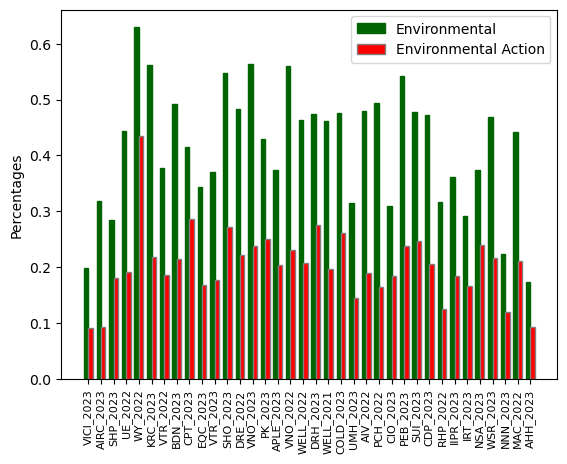

In [9]:
# Visualize the ratios for the companies.
# Sample data
categories = list(pdf_dict.keys())
values1 = env_pcts
values2 = envact_pcts

# Set the bar width
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = np.arange(len(categories))
r2 = [x + bar_width for x in r1]

# Create the grouped bar plot
plt.bar(r1, values1, color='darkgreen', width=bar_width, edgecolor='darkgreen', label='Environmental')
plt.bar(r2, values2, color='red', width=bar_width, edgecolor='grey', label='Environmental Action')

# Add labels, title, and legend
plt.ylabel('Percentages')
plt.xticks([r + bar_width/2 for r in range(len(categories))], categories, rotation=90, fontsize=8)
plt.legend()

# Show the plot
plt.show()


Interesting. I'll leave you to interpret this. Keep in mind: The BlackRock Annual Report is not of the whole company but it's exchange portfolio.

# Caveat

If you take a closer look at the results then you might find that some sentences are not actually environmental or action. This may lie in biases or shortcomings in the training data. No system is perfect. Particularily, the "action" dataset only contains 500 entries. Thus, fine-tuning your own models with extensions of the datasets might be a good strategy. Since I [open-source all datasets](https://huggingface.co/ESGBERT) on HuggingFace, you can use mine as a basis for further extensions.

I will address fine-tuning of models in the next tutorial. It's actually quite straightforward. Until then, feel free to read the [paper on the ESG BERTs](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4622514) or follow [me on LinkedIn](https://www.linkedin.com/in/tobias-schimanski-964077182/) to not miss out on new developments.

Second Tutorial is [here](https://medium.com/@schimanski.tobi/analyzing-esg-with-ai-and-nlp-tutorial-2-large-scale-analyses-of-environmental-actions-0735cc8dc9c2).